In [1]:
import os
import numpy as np
from scipy.optimize import minimize
from ghgf.hgf import StandardHGF
from ghgf.plots import plot_trajectories
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.plotting import show
output_notebook()

sns.set_context('talk')

Loading BokehJS ...

# Example of surprise minimization

For now, we've only used binary input - 0 or 1. However, many of the most interesting time series are on a continuous scale. As an example, we'll use the exchange rate of the US Dollar to the Swiss Franc during much of 2010 and 2011.

Read USD-CHF data.

In [2]:
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
usdchf = np.loadtxt(f"{path}/tests/data/usdchf.dat")

## Continuous HGF
### Model fitting

Set up standard 2-level HGF for continuous inputs.

In [31]:
stdhgf = StandardHGF(
    n_levels=2,
    model_type="GRW",
    initial_mu={"1": 1.04, "2": 1.0},
    initial_pi={"1": 1e4, "2": 1e1},
    omega={"1": -13.0, "2": -2.0},
    rho={"1": 0.0, "2": 0.0},
    kappa={"1": 1.0}
)

Initializing a 2 levels perceptual HGF using a GRW model.


Provide perceptial input to the model (filtering).

In [32]:
stdhgf.input(usdchf)

### Parameters correlation

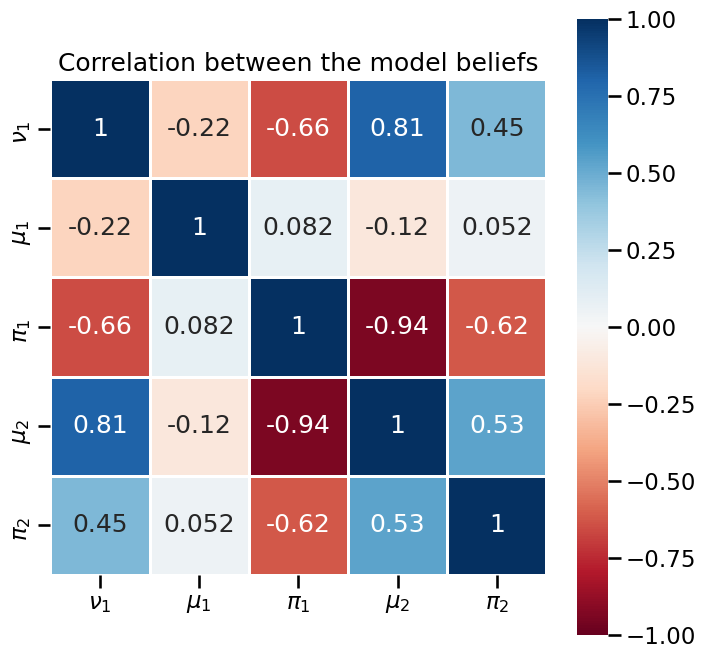

In [6]:
import pandas as pd

# Input time series
df = pd.DataFrame({r'$\nu_{1}$': np.array(stdhgf.x1.nus[1:])})

# Values times series
for i in range(stdhgf.n_levels):
    l = "{" + str(i+1) + "}"
    mu_serie = getattr(stdhgf, f"x{i+1}").mus[1:]
    mu_name = fr"$\mu_{l}$"
    pi_serie = getattr(stdhgf, f"x{i+1}").pis[1:]
    pi_name = fr"$\pi_{l}$"
    df = pd.concat([df, pd.DataFrame({mu_name: mu_serie, pi_name: pi_serie})], axis=1)

correlation_mat = df.corr()

plt.figure(figsize=(8, 8))
plt.title("Correlation between the model beliefs")
sns.heatmap(correlation_mat, annot=True, cmap='RdBu', vmin=-1, vmax=1, linewidths=2, square=True)
plt.show()

### Parameters trajectories

In [7]:
show(
    plot_trajectories(model=stdhgf, ci=True, figsize=800)
)

Looking at the volatility (ie, the second) level, we see that there are two salient events in our time series where volatility shoots up. The first is in April 2010 when the currency markets react to the news that Greece is effectively broke. This leads to a flight into the US dollar (green dots rising very quickly), sending the volatility higher. The second is an accelarating increase in the value of the Swiss Franc in Augutst and September 2011, as the Euro crisis drags on. The point where the Swiss central bank intervened and put a floor under how far the Euro could fall with respect to the Franc is clearly visible in the Franc's valuation against the dollar. This surprising intervention shows up as another spike in volatitlity.

### Surprize minimization

Choose priors.

In [33]:
stdhgf.x1.initial_mu.trans_prior_mean = 1.0375
stdhgf.x1.initial_mu.trans_prior_precision = 4.0625e5
stdhgf.x1.initial_pi.trans_prior_mean = -10.1111
stdhgf.x1.initial_pi.trans_prior_precision = 1
stdhgf.x1.omega.trans_prior_mean = -10.1111
stdhgf.x1.omega.trans_prior_precision = 1
stdhgf.x2.initial_pi.trans_prior_mean = -2.3026
stdhgf.x2.initial_pi.trans_prior_precision = 1
stdhgf.x2.omega.trans_prior_mean = -4
stdhgf.x2.omega.trans_prior_precision = 1
stdhgf.xU.omega.trans_prior_mean = -10.1111
stdhgf.xU.omega.trans_prior_precision = 1

Get the objective function.

In [34]:
stdobjf = stdhgf.neg_log_joint_function()

Minimize the negative log-joint.

In [35]:
stdmin = minimize(stdobjf, stdhgf.var_param_trans_values)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [36]:
show(
    plot_trajectories(model=stdhgf, ci=True, figsize=800)
)